In [75]:
# imports
import pandas as pd
import numpy as np
import streamlit as st
import os
import datetime as dt
from dateutil.relativedelta import relativedelta
import requests
import pickle

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pydeck as pdk

In [76]:
# title of app
st.title('Exploration Resale Prices of Public Housing in Singapore')
st.write('\n')
st.write('\n')

# Load data

In [77]:
# cache data for quicker loading
@st.cache
# load data from csv
def load_data_from_csv(file_path):
    # read data
    data = pd.read_csv(file_path)
    # convert to year_month to datetime format
    data['year_month'] = pd.to_datetime(data['year_month'])
    # convert latitude and longitude to numeric
    data[['latitude', 'longitude']] = data[['latitude', 'longitude']].apply(pd.to_numeric)
    # return 
    return data

# define data directory
data_folder = 'data'
# create empty dataframe to concat data later
data = pd.DataFrame()
# loop through each file in data_folder and concat into one df
for file_name in os.listdir(data_folder):
    # load data
    temp_data = load_data_from_csv(os.path.join(data_folder, file_name))
    # concat data
    data = pd.concat([data, temp_data])

In [78]:
# get date range of full data set
min_data_date = data['year_month'].min().strftime('%B %Y')
max_data_date = data['year_month'].max().strftime('%B %Y')
total_row_count = '{:,}'.format(len(data))

# introduction to app
st.write(f'The data has been extracted from Data.gov.sg.')
st.write(f'There are a total of {total_row_count} recorded resale flat transactions from {min_data_date} to {max_data_date}.')
st.write('\n')
st.write('\n')

In [84]:
### map using latitude and longitude ###

# cache data
@st.cache
# filter data for map due to memory limit in streamlit
def filter_data_for_map(data, years):
    # get number of years to filter
    map_date = data['year_month'].max() - relativedelta(years=years)
    # filter data for map by years
    data_for_map = data.loc[(data['year_month'] >= map_date)]
    # return
    return data_for_map

# filter data for map due to memory limit in streamlit
data_for_map = filter_data_for_map(data, 3)

# describe map
st.write(f'Heat map of number of flat transactions in the past three years.')
st.write('There is a memory limit hence need for the restriction of three years.')

# create pydeck map in streamlit
def pydeck_map(data_for_map):
    # create map from pydeck
    layer=[
        pdk.Layer(
            'HexagonLayer',
            data=data_for_map,
            get_position='[longitude, latitude]',
            radius=40,
            elevation_scale=3,
            elevation_range=[0,500],
            pickable=True,
            extruded=True,
        ),
        pdk.Layer(
            'ScatterplotLayer',
            data=data_for_map,
            get_position='[longitude, latitude]',
            get_color='[200, 30, 0, 160]',
            get_radius=40,
        )
    ]

    st.pydeck_chart(pdk.Deck(
        initial_view_state=pdk.ViewState(latitude=1.355, longitude=103.81, zoom=12, pitch=40),
        layers=layer
        ))

# create pydeck map in streamlit
pydeck_map(data_for_map)

In [83]:
# # test size of pydeck map data
# layer = [
#     pdk.Layer(
#         'HexagonLayer',
#         data=data_for_map,
#         get_position='[longitude, latitude]',
#         radius=40,
#         elevation_scale=3,
#         elevation_range=[0, 500],
#         extruded=True,
#     ),
#     pdk.Layer(
#     'ScatterplotLayer',
#     data=data_for_map,
#     get_position='[longitude, latitude]',
#     get_color='[200, 30, 0, 160]',
#     get_radius=40,
#     )
# ]

# # Combined all of it and render a viewport
# r = pdk.Deck(layers=[layer], initial_view_state=pdk.ViewState(latitude=1.355, longitude=103.81, zoom=12, pitch=40))
# r.to_html('hexagon-example.html')

In [ ]:
# slider to select past n number of years of data to use

# set default value to past 10 years
# set to use at least past 1 year of data
# determine max number of years from data
max_past_n_years = round((data['year_month'].max() - data['year_month'].min()) / np.timedelta64(1, 'Y')) + 1
# define slider
past_n_years = st.slider('# How many years of past data would you like to use?', min_value=1, max_value=max_past_n_years, value=10)

In [ ]:
# filter number of years of data to use based on slider

# define latest year of data
latest_year = str(data['year_month'].max().year - past_n_years)
# filter past n number of years
data = data.loc[(data['year_month'] >= latest_year+'-01-01')]

# Visualise data

In [74]:
# ### histogram of flat prices ###

# # set plot and figure size
# fig, ax = plt.subplots(figsize=(15,10))

# ax = sns.scatterplot(
#     x='longitude',
#     y='latitude',
#     data=data,
#     hue='town'
# )

# # set title
# ax.set_title('Resale Flat Price')

# # show plot
# st.pyplot(fig)

2021-09-16 16:00:14.173 NumExpr defaulting to 8 threads.


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

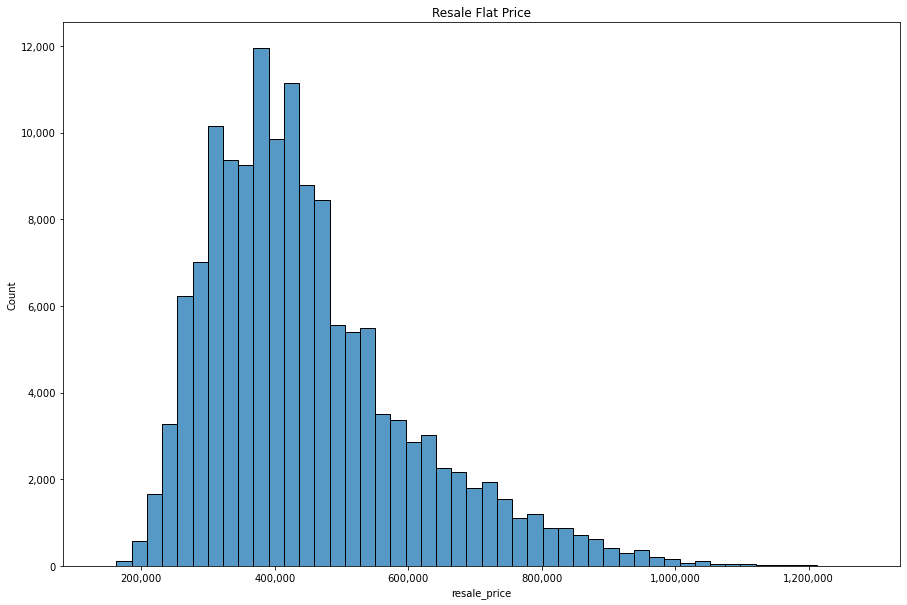

In [12]:
### histogram of flat prices ###

# set plot and figure size
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.histplot(
    x='resale_price',
    data=data,
    bins=50
)

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Resale Flat Price')

# show plot
st.pyplot(fig)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

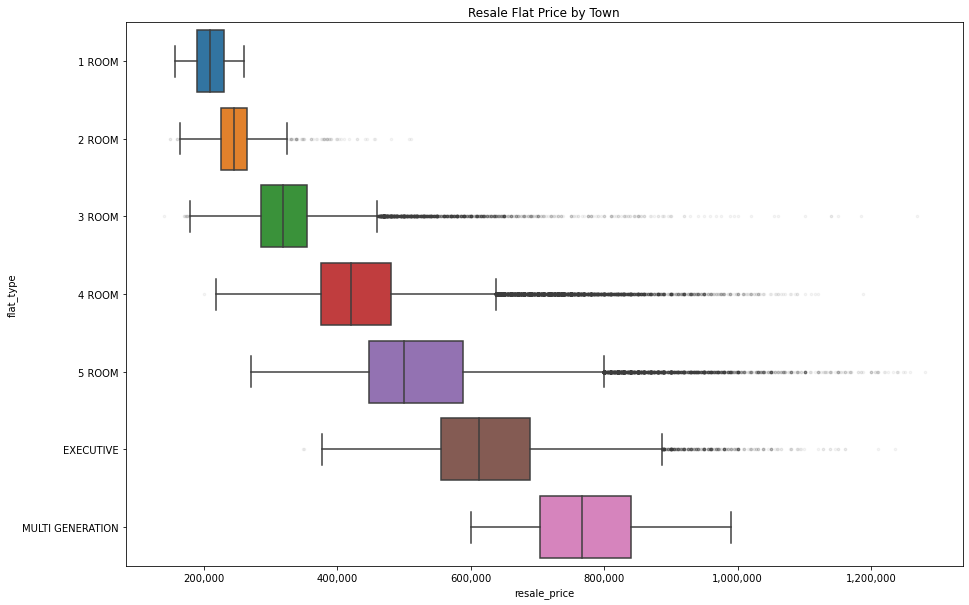

In [24]:
### boxplot of flat type ###

# set plot and figure size
fig, ax = plt.subplots(figsize=(15,10))

# order by flat_type alphabetically
flat_type_order = sorted(list(data['flat_type'].unique()))
# plot ax
ax = sns.boxplot(
    x='resale_price', 
    y='flat_type', 
    data=data,
    order=flat_type_order, 
    flierprops={'marker':'.', 'alpha':0.05}
    )

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Resale Flat Price by Town')

# show plot
st.pyplot(fig)

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

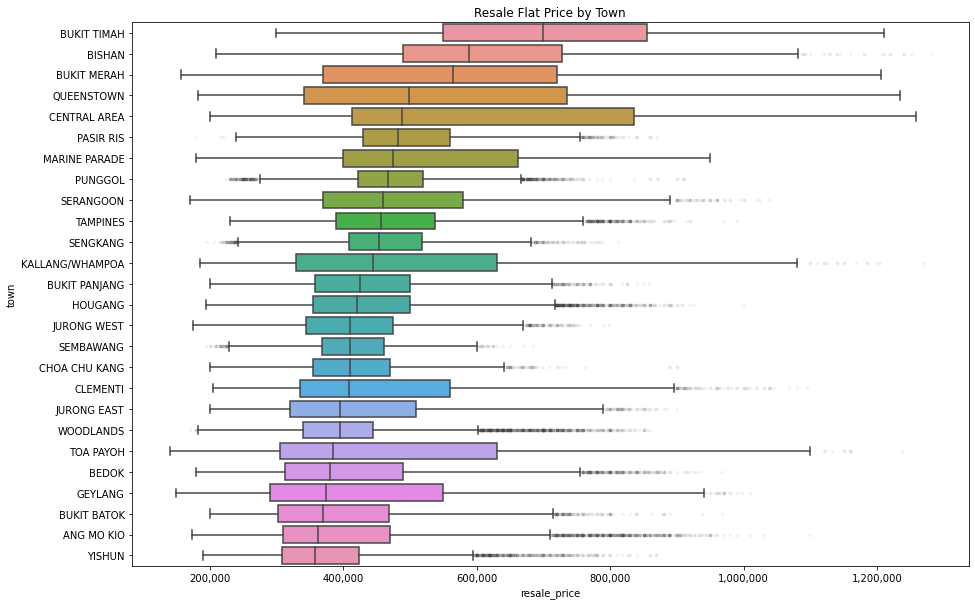

In [25]:
### boxplot of town ###

# set plot and figure size
fig, ax = plt.subplots(figsize=(15,10))

# order by descending median resale_price
town_order = list(data.groupby(['town']).agg({'resale_price':'median'}).reset_index().sort_values('resale_price', ascending=False)['town'])
# plot boxplot
sns.boxplot(
    x='resale_price', 
    y='town', 
    data=data, 
    order=town_order,
    flierprops={'marker':'.', 'alpha':0.05}
    )

# formatting
# add thousands separator
ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# set title
ax.set_title('Resale Flat Price by Town')
# show ploy
st.pyplot(fig)

# Prediction

In [35]:
# prediction section
st.write('# Predict Resale Flat Price')
st.write('Enter some basic information of your flat to for the model to predict it\'s resale price')

# form to store users input
with st.form(key='input_form'):

    # ask and store users input
    input_postal_code = st.text_input(label='Postal Code')
    input_floor_area_sqm = st.number_input(label='Floor Area (square meters)', min_value=1)
    input_floor = st.number_input(label='Floor', min_value=1)
    input_lease_commence_year = st.number_input(label='Lease Commence (year)', min_value=1)

    # get coordinates from address as latitude and longitude using google geocode api
    def get_coordinates_from_address(address, api_key):
        '''
        get coodinates from an address using google geocode api
        information on how to set up and create api key can be found here
        https://developers.google.com/maps/documentation/geocoding/overview?hl=en_GB

        arguments:
        address (str): address to get coordinates of
        api_key (str): api key from google cloud platform

        returns:
        a tuple containing latitude and longitude
        '''
        # request response from google geocode api
        api_response = requests.get(f'https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}').json()
        # check if api response is 'OK'
        if api_response['status'] == 'OK':
            # get latitude from response
            latitude = api_response['results'][0]['geometry']['location']['lat']
            # get longitude from response
            longitude = api_response['results'][0]['geometry']['location']['lng']
        else:
            # if status is not 'OK', add status as error message
            latitude = 'error: ' + api_response['status']
            longitude = 'error: ' + api_response['status']

        # return a tuple
        return (latitude, longitude)

    # get latitude and longitude from postal code
    coordinates = get_coordinates_from_address(input_postal_code+' Singapore', st.secrets['geocode_api_key'])
    # calculate remaining lease years from lease commencement date
    input_remaining_lease_years = dt.date.today().year - input_lease_commence_year

    # format user inputs into df for xgb prediction
    input_data = pd.DataFrame({
        'latitude':[coordinates[0]],
        'longitude':[coordinates[1]],
        'floor_area_sqm':[input_floor_area_sqm],
        'floor':[input_floor],
        'remaining_lease_years':[input_remaining_lease_years]
    })

    # submit form button
    st.write('Load inputs to machine learning model to prepare for a prediction:')
    submit = st.form_submit_button(label='Load')

In [36]:
# load model
model = pickle.load(open('xgb_baseline.pkl', 'rb'))

# describe predict button
st.write('Take a guess at the price before running the model!')

# add predict button
if st.button('Predict'):
    # predict input_data using model
    prediction = model.predict(input_data)[0]
    # format prediction with thousands separator and round to two decimal places
    prediction = '{:,.2f}'.format(round(prediction, 2))
    # print prediction
    st.write(f'The predicted resale flat price is ${prediction}.')